In [2]:
from typing import Any, Optional, Callable
from numpy.typing import ArrayLike, NDArray
from pandas import DataFrame

import numpy as np
import random

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

from cpscheduler.common_envs import JobShopEnv
from cpscheduler.environment import WeightedCompletionTime, SchedulingCPEnv, PrecedenceConstraint, NonOverlapConstraint, Env, AsyncVectorEnv, register_env
from cpscheduler.policies.heuristics import ShortestProcessingTime, WeightedShortestProcessingTime

from cpscheduler.environment.instances import generate_taillard_instance

# Generate Customer-based Scheduling Dataset

The customer-based Scheduling Dataset is a collection of JobShop instances with an additional feature for each job, linking every job to a given customer. Customers may seen as the ones who ordered the job, or any other characteristic that may affect a given priority for the job to be completed. We assume the job's customer is drawn from a categorical distribution of a finite pool of possible customers, with different oracle priority values, related to the probability of such customer to contract.

We first suppose these probabilities and priorities do not change over time, however this may sound unrealistic, the priority of a job is not fully determined by the customer priority, and can change in various unpredictable ways. We model this uncertainty by addressing a customer uncertainty to the priority, the job priority is then sampled from this distribution and revealed to the online policy, which takes decision with the sampled priority, which will be further unknown.

In [2]:
n_customers = 1000
n_machines = 50

# Generate random data
rng = np.random.default_rng(seed=0)

desired_prob_variance = 100
sample_uncertainty = 0.1

alpha = 1+rng.exponential(desired_prob_variance**2, n_customers).astype(np.int32)
alpha = desired_prob_variance * alpha / alpha.sum()
customer_probabilities = rng.dirichlet(alpha)

oracle_priorities  = (1+customer_probabilities) * rng.uniform(0.66, 1.5, n_customers)
customer_uncertainty = rng.uniform(0, oracle_priorities * sample_uncertainty)

def sample_priorities(seed: Optional[int] = None) -> NDArray[np.float32]:
    rng = np.random.default_rng(seed)

    return rng.normal(oracle_priorities, customer_uncertainty).astype(np.float32)

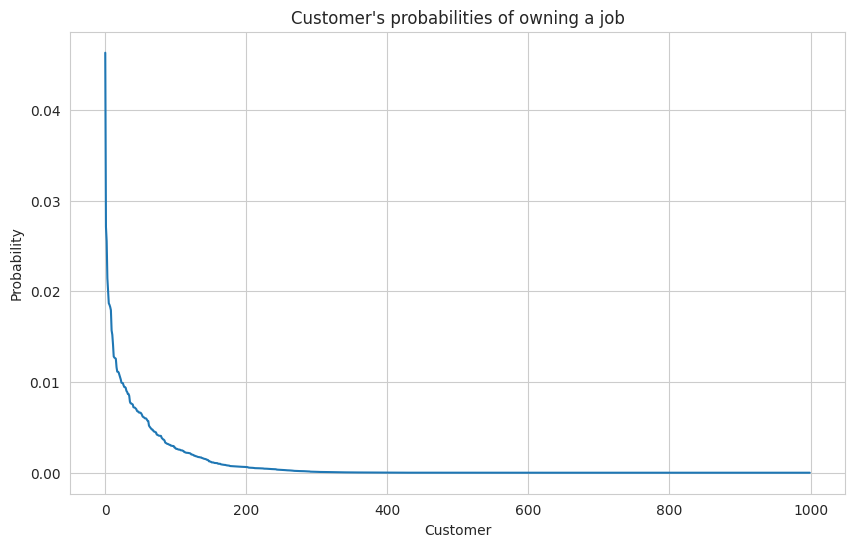

In [3]:
fig = plt.figure(figsize=(10, 6))

plt.title("Customer's probabilities of owning a job")

plt.plot(-np.sort(-customer_probabilities))

plt.xlabel("Customer")
plt.ylabel("Probability")

plt.show()

In [4]:
class CustomerJobShopEnv(SchedulingCPEnv):
    def __init__(
            self,
            instance: DataFrame,
            duration: str | NDArray[np.int32] = 'processing_time',
            customer_weights: NDArray[np.float32] = np.ones(n_customers, dtype=np.float32),
            job_feature: str = 'job',
            customer_feature: str = 'customer',
            operation_feature: str = 'operation',
            machine_feature: str = 'machine'
        ) -> None:
        super().__init__(instance, duration)
        self.add_constraint(
            PrecedenceConstraint.jobshop_precedence(self.tasks, job_feature, operation_feature)
        )

        self.add_constraint(
            NonOverlapConstraint.jobshop_non_overlap(self.tasks, machine_feature)
        )

        n_jobs = len(np.unique(self.tasks[job_feature]))

        weights = np.zeros(n_jobs, dtype=np.float32)
        weights[self.tasks[job_feature]] = customer_weights[self.tasks[customer_feature]]

        self.set_objective(
            WeightedCompletionTime(self.tasks, job_feature, weights)
        )

    def render(self) -> None:
        return self.render_gantt(
            'machine',
            'job',
        )

register_env(CustomerJobShopEnv, 'customer_jobshop')

We sample random jobshop instances, with different job and operation characteristics, linked to a specific customer. Solutions are then sampled from different behavior patterns:
- Optimal proxy: The solutions are optimal to the weigthed completion time jobshop problem, taking priority values as weights for each job.
- Perturbed Expert solutions: Optimal solutions are perturbed by one or more of the other behavior pattern.
- Expert trajectories: A RL algorithm is trained to optimize the weigthed completion time jobshop problem with known priorities.
- PDR solutions: Solutions are taken from different PDR leveraging approximate job priorities.
- Biased solutions: Solutions taken from PDRs with no or minimal dependency with the priority values.

We consider the solutions, from top to bottom, as in decreasing order of trajectory quality and we build different datasets with different quality levels.

## Taillard Instances

Taillard instances were originally proposed to the makespan jobshop scheduling problem, usually used for benchmarking algorithms due to instances with existing solutions that can be compared across different strategies. It is a simple static scenario with deterministic processing times, and no uncertainty

In [5]:
def generate_customers_taillard(
    n_jobs: int,
    n_machines: int,
    customers_probabilities: NDArray[np.float64],
    seed: Optional[int] = None
) -> tuple[DataFrame, dict[str, Any]]:
    rng = np.random.default_rng(seed=seed)

    instance, metadata = generate_taillard_instance(n_jobs, n_machines, seed=seed)

    customers = rng.choice(n_customers, n_jobs, p=customers_probabilities)

    instance["customer"] = customers[instance["job"]]

    return instance, metadata

In [9]:
def make_customer_env(
        n_jobs: int,
        n_machines: int,
    ) -> Callable[[], JobShopEnv]:

    integer_oracle_priorities = oracle_priorities # (100 * oracle_priorities).astype(np.int32)

    def env_fn() -> JobShopEnv:
        instance, metadata = generate_customers_taillard(n_jobs, n_machines, customer_probabilities)

        env = JobShopEnv(instance)

        env.objective = WeightedCompletionTime(env.tasks, 'customer', integer_oracle_priorities)

        return env

    return env_fn

In [10]:
env = make_customer_env(10, 5)()
env.reset()

(array([( 0, 0, 0, 1, 28, 669, 28, 'available'),
        ( 1, 0, 1, 3, 19, 669, 19, 'awaiting'),
        ( 2, 0, 2, 2, 36, 669, 36, 'awaiting'),
        ( 3, 0, 3, 4, 70, 669, 70, 'awaiting'),
        ( 4, 0, 4, 0, 90, 669, 90, 'awaiting'),
        ( 5, 1, 0, 3, 28, 422, 28, 'available'),
        ( 6, 1, 1, 4, 47, 422, 47, 'awaiting'),
        ( 7, 1, 2, 0, 66, 422, 66, 'awaiting'),
        ( 8, 1, 3, 2,  5, 422,  5, 'awaiting'),
        ( 9, 1, 4, 1, 38, 422, 38, 'awaiting'),
        (10, 2, 0, 1, 16, 156, 16, 'available'),
        (11, 2, 1, 0,  3, 156,  3, 'awaiting'),
        (12, 2, 2, 3, 31, 156, 31, 'awaiting'),
        (13, 2, 3, 2, 20, 156, 20, 'awaiting'),
        (14, 2, 4, 4, 31, 156, 31, 'awaiting'),
        (15, 3, 0, 1, 93, 263, 93, 'available'),
        (16, 3, 1, 2, 70, 263, 70, 'awaiting'),
        (17, 3, 2, 0, 29, 263, 29, 'awaiting'),
        (18, 3, 3, 4, 60, 263, 60, 'awaiting'),
        (19, 3, 4, 3, 57, 263, 57, 'awaiting'),
        (20, 4, 0, 4, 64, 682, 64, '

In [12]:
print(env.objective.export_objective())

job0_completion = max([]);
job1_completion = max([]);
job2_completion = max([]);
job3_completion = max([]);
job4_completion = max([]);
job5_completion = max([]);
job6_completion = max([]);
job7_completion = max([]);
job8_completion = max([]);
job9_completion = max([]);
job10_completion = max([]);
job11_completion = max([]);
job12_completion = max([]);
job13_completion = max([]);
job14_completion = max([]);
job15_completion = max([]);
job16_completion = max([]);
job17_completion = max([]);
job18_completion = max([]);
job19_completion = max([]);
job20_completion = max([]);
job21_completion = max([]);
job22_completion = max([]);
job23_completion = max([]);
job24_completion = max([]);
job25_completion = max([]);
job26_completion = max([]);
job27_completion = max([]);
job28_completion = max([]);
job29_completion = max([]);
job30_completion = max([]);
job31_completion = max([]);
job32_completion = max([]);
job33_completion = max([]);
job34_completion = max([]);
job35_completion = max([]);
jo

In [8]:
env.get_cp_solution()

OverflowError: Python integer -9007199254740991 out of bounds for int32

In [ ]:
n_optimal_samples = 64

envs = AsyncVectorEnv([make_customer_env(rng.integers(10, 50).item(), n_machines) for _ in range(n_optimal_samples)])
envs.reset()

start_times, task_order, objective_values, is_optimal = envs.call(
    'get_cp_solution'
)

ExceptionGroup: Error during get_cp_solution in 64 environments out of 64:
 (64 sub-exceptions)

In [ ]:
n_taillard_samples = 364
n_envs_per_priority = 7


envs = AsyncVectorEnv([make_customer_env(rng.integers(10, 50).item(), n_machines) for _ in range(n_optimal_samples)])
envs.reset()

In [ ]:
actions = []

for i in range(n_taillard_samples // n_envs_per_priority):
    envs = AsyncVectorEnv([make_customer_env(rng.integers(10, 50).item(), n_machines) for _ in range(n_optimal_samples)])

    uncertain_priorities = sample_priorities()

    spt = WeightedShortestProcessingTime(
        uncertain_priorities,
        weighted_label='customer',
    )

    actions.extend(spt(obs[i * n_envs_per_priority: (i + 1) * n_envs_per_priority]))

actions = np.array(actions)

_, _, _, _, infos = env.step(actions, enforce_order=False)

actions = np.array(infos['solution'])

In [ ]:
from typing import Any, Optional, Iterable, Callable, Mapping, Never, overload, Union
from numpy.typing import NDArray, ArrayLike
from torch.types import Tensor, Device
from pandas import DataFrame

from pathlib import Path

import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from tensordict import TensorDict

from multiprocessing import cpu_count

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

import math
from functools import partial

from cpscheduler.environment import SchedulingCPEnv, Env, AsyncVectorEnv, VectorEnv, SyncVectorEnv
from cpscheduler.environment.instances import generate_taillard_instance, read_jsp_instance
from cpscheduler.environment.wrappers import wrap_action, wrap_obs
from cpscheduler.algorithms import BaseAlgorithm, Buffer, Logs
from cpscheduler.utils import merge_and_pad

from cpscheduler.common_envs import JobShopEnv

root = Path().absolute().parent

In [ ]:
def build_state(obs: NDArray[np.void], env: SchedulingCPEnv, n_future_tasks: int = 3):
    jobs = np.unique(obs['job'])

    is_fixed = env.tasks.is_fixed()
    lower_bound = env.tasks.start_lb[:]

    order = np.argsort(obs, order=['job', 'operation'])

    obs         = obs[order]
    is_fixed    = is_fixed[order]
    lower_bound = lower_bound[order]

    state      = np.ones((len(jobs), 2+n_future_tasks, 7), dtype=np.int32)
    input_mask = np.ones((len(jobs), 2+n_future_tasks), dtype=np.bool)

    for i, job in enumerate(jobs):
        job_obs = obs[obs['job'] == job]
        job_customer = job_obs['customer'][0]

        last_finished = np.max(job_obs['operation'][job_obs['buffer'] == 'finished'], initial=-1)
        n_jobs = len(job_obs)

        job_ops = [op if (0 <= op < n_jobs) else -1 for op in range(last_finished, last_finished+n_future_tasks+2)]

        input_mask[i, :] = (np.asarray(job_ops) == -1)
 
        state[i, :, 0] = is_fixed[obs['job'] == job][job_ops]
        state[i, :, 1] = lower_bound[obs['job'] == job][job_ops]
        state[i, :, 2] = job_obs[job_ops]['processing_time']
        state[i, :, 3] = job_obs[job_ops]['buffer'] == 'available'
        state[i, :, 4] = job_obs[job_ops]['machine']
        state[i, :, 5] = job_customer
        state[i, :, 6] = job_ops

    state[input_mask, :5] = 0
    return state, input_mask


def recover_action(job_idx: int, env: SchedulingCPEnv, n_jobs: int) -> Optional[int]:
    if job_idx >= n_jobs:
        return None

    obs = env._get_obs()

    try:
        return obs[(obs['job'] == job_idx) & (obs['buffer'] == 'available')]['task_id'].item()
    
    except ValueError:
        print(obs[(obs['job'] == job_idx) & (obs['buffer'] == 'available')])

        raise ValueError(f'No available task for job {job_idx}')


def unpack_obs(obs: Iterable[tuple[ArrayLike, ...]], device: Device) -> tuple[Tensor, ...]:
    states, mask = zip(*obs)

    states = merge_and_pad(states, 0)
    mask   = merge_and_pad(mask, True)

    return torch.tensor(states, device=device), torch.tensor(mask, device=device)

class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, max_len: int = 100):
        super().__init__()
        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, d_model)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

        self.pe = pe

    def forward(self, positions: Tensor) -> Tensor:
        return self.pe[positions]


def layer_init(layer: nn.Module, gain: int = 1, bias_const=0.0) -> nn.Module:
    torch.nn.init.orthogonal_(layer.weight, gain)

    if hasattr(layer, "bias") and layer.bias is not None:
        torch.nn.init.constant_(layer.bias, bias_const)
    
    return layer


class End2EndActor(nn.Module):
    def __init__(
            self,
            d_model: int,
            n_heads: int = 1,
            n_layers: int = 1,
            dropout: float = 0.,
            n_customers: int = 1000
        ):
        super().__init__()

        self.d_model = d_model

        self.embedding_fixed = nn.Embedding(2, 1)
        self.embedding_legal_op = nn.Embedding(2, 1)
        self.embedding_customer = nn.Embedding(n_customers, d_model)

        self.obs_projection = nn.Linear(4+d_model, d_model)
        layer_init(self.obs_projection)

        self.pos_encoder = PositionalEncoding(d_model)

        transformer_encoder = nn.TransformerEncoderLayer(
            d_model, n_heads, dim_feedforward=4*d_model, dropout=dropout, batch_first=True, norm_first=True
        )

        action_layer = nn.TransformerEncoderLayer(
            d_model, n_heads, dim_feedforward=4*d_model, dropout=dropout, batch_first=True, norm_first=True
        )

        self.job_encoder = nn.TransformerEncoder(
            transformer_encoder,
            n_layers,
            enable_nested_tensor=False
        )

        self.action_transformer = nn.TransformerEncoder(
            action_layer,
            n_layers,
            enable_nested_tensor=False
        )

        self.jobs_action = nn.Sequential(
            layer_init(nn.Linear(d_model, out_features=4*d_model)),
            nn.Tanh(),
            layer_init(nn.Linear(4*d_model, 1))
        )

        self.no_op_action = nn.Sequential(
            layer_init(nn.Linear(d_model, 4*d_model)),
            nn.Tanh(),
            layer_init(nn.Linear(4*d_model, 1))
        )


    def forward(self, obs: Tensor, input_mask: Tensor):
        embedded_obs = torch.cat((
            self.embedding_fixed(obs[:, :, :, 0].long()),
            obs[:, :, :, 1:3],
            self.embedding_legal_op(obs[:, :, :, 3].long()),
            self.embedding_customer(obs[:, :, :, 5].long())),
        dim=3)

        batch_size, n_jobs, n_ops, n_features = embedded_obs.shape

        pos_encoding = self.pos_encoder(obs[:, :, :, -1].long())
        proj_obs = self.obs_projection(embedded_obs) + pos_encoding

        encoded_jobs = self.job_encoder(
            proj_obs.view(-1, n_ops, self.d_model),
            src_key_padding_mask=input_mask.view(-1, n_ops)
        ).view(batch_size, n_jobs, n_ops, self.d_model)

        # There's a chance something down here is wrong

        encoded_jobs = encoded_jobs.mean(dim=2)

        machines     = obs[:, :, 1, 4].squeeze().float()
        finished_job = input_mask[:, :, 1]

        job_resource_mask = ~(machines.unsqueeze(1) == machines.unsqueeze(-1))

        encodings = self.action_transformer(encoded_jobs, src_key_padding_mask=finished_job, mask=job_resource_mask)

        job_final = self.jobs_action(encodings)
        no_op     = self.no_op_action(encodings)

        logits = torch.cat((job_final.squeeze(2), no_op.mean(dim=1)), dim=1)

        available_jobs = obs[:, :, 1, 3].squeeze().bool()

        no_op_mask = torch.ones(batch_size, 1, dtype=torch.bool, device=obs.device)
        mask = torch.cat((available_jobs, no_op_mask), dim=1)

        logits = torch.masked_fill(logits, ~mask, -torch.inf)

        return logits

In [ ]:
class End2End(BaseAlgorithm):
    def __init__(
            self,
            agent: nn.Module,
            optimizer: optim.Optimizer,
            device: Device = 'cuda',
            n_envs: int = 128,
            *,
            buffer_size: int = 100000,
            n_future_tasks: int = 3,
            clip_coef: float = 0.3,
            reward_norm: bool = True,
            anneal_lr: bool = True
        ):
        buffer_shapes = {
            'obs': (10, 2+n_future_tasks, 7),
            'mask': (10, 2+n_future_tasks),
            'action': (),
            'log_prob': (),
            'returns': (),
        }

        buffer = Buffer(buffer_size, buffer_shapes, device)

        super().__init__(buffer)

        self.agent = agent
        self.optimizer = optimizer

        self.n_future_tasks = n_future_tasks
        self.clip_coef = clip_coef
        self.reward_norm = reward_norm
        self.anneal_lr = anneal_lr

        self.n_envs = n_envs

    
    def on_session_start(self, num_updates: int, steps_per_update: int, batch_size: int):
        if self.anneal_lr:
            self.lr_delta = self.optimizer.param_groups[0]['lr'] / num_updates


    def on_epoch_start(self) -> Logs:
        self.agent.eval()
        self.buffer.clear()

        envs = AsyncVectorEnv([make_customer_env(10, 10) for _ in range(self.n_envs)], auto_reset=False)

        max_horizon = self.buffer.capacity // self.n_envs

        obs, info = envs.reset()

        observations = torch.empty((self.n_envs, max_horizon, *self.buffer.buffer_shapes['obs']), dtype=torch.float32)
        masks        = torch.empty((self.n_envs, max_horizon, *self.buffer.buffer_shapes['mask']), dtype=torch.bool)
        actions      = torch.empty((self.n_envs, max_horizon, *self.buffer.buffer_shapes['action']), dtype=torch.int64)
        log_probs    = torch.empty((self.n_envs, max_horizon, *self.buffer.buffer_shapes['log_prob']), dtype=torch.float32)
        running_mask = torch.zeros((self.n_envs, max_horizon), dtype=torch.bool)

        no_op = torch.zeros(self.n_envs, dtype=torch.int32)

        i = 0
        running = torch.ones(self.n_envs, dtype=torch.bool)
        while torch.any(running):
            tensor_obs, tensor_mask = unpack_obs(obs, self.device)

            observations[:, i] = tensor_obs
            masks[:, i]        = tensor_mask

            with torch.no_grad():
                logits = self.agent(tensor_obs, tensor_mask)

            categorical = torch.distributions.Categorical(logits=logits)

            action   = categorical.sample()
            log_prob = categorical.log_prob(action)

            actions[:, i]   = action
            log_probs[:, i] = log_prob

            obs, reward, terminated, truncated, info = envs.step(action.cpu().numpy())

            running_mask[:, i] = running
            running = ~torch.tensor(terminated, dtype=torch.bool)

            no_op += torch.where(running, action.cpu() == 10, 0)

            i += 1

        returns = torch.tensor(info['objective_value'], dtype=torch.float32)

        self.buffer.add(
            obs      = observations[running_mask],
            mask     = masks[running_mask],
            action   = actions[running_mask],
            log_prob = log_probs[running_mask],
            returns  = -returns.repeat(max_horizon, 1).T[running_mask]
        )

        envs.close()

        return Logs().extend({
            'objective': returns.tolist(),
            'no_op_actions': no_op.tolist()
        })


    def update(self, batch: TensorDict) -> dict[str, Any]:
        logits = self.agent(batch['obs'], batch['mask'])

        log_prob = torch.distributions.Categorical(logits=logits).log_prob(batch['action'])

        log_ratio = log_prob - batch['log_prob']
        ratio = torch.exp(log_ratio)

        with torch.no_grad():
            # calculate approx_kl http://joschu.net/blog/kl-approx.html
            approx_kl     = torch.mean((ratio - 1) - log_ratio)

        returns = batch['returns']
        if self.reward_norm:
            returns = (returns - returns.min()) / (returns.max() - returns.min())

        if approx_kl > 1000:
            for i, action in enumerate(batch['action']):
                if logits[i, action] < -100:
                    print(action, logits[i])
                    print(batch['log_prob'][i])
                    print(batch['obs'][i, action])

            raise ValueError(f'approx_kl is too high: {approx_kl}')

        pg_loss1 = -returns * ratio
        pg_loss2 = -returns * torch.clamp(ratio, 1 - self.clip_coef, 1 + self.clip_coef)
        pg_loss = torch.max(pg_loss1, pg_loss2).mean()

        pg_loss.backward()
        self.optimizer.step()
        self.optimizer.zero_grad()

        return {
            'loss': pg_loss.item(),
            'approx_kl': approx_kl.item(),
        }


    def on_epoch_end(self) -> dict[str, Any]:
        epoch_lr = self.optimizer.param_groups[0]['lr']

        if self.anneal_lr:
            self.optimizer.param_groups[0]['lr'] = max(epoch_lr - self.lr_delta, 1e-6)

        return {
            'learning rate': epoch_lr
        }

In [ ]:
def make_customer_env(
        n_jobs: int,
        n_machines: int,
    ) -> Callable[[], Env]:

    integer_oracle_priorities = (100 * oracle_priorities).astype(np.int32)

    def env_fn() -> Env:
        instance, metadata = generate_customers_taillard(n_jobs, n_machines, customer_probabilities)

        env = JobShopEnv(instance)

        env.objective = WeightedCompletionTime(env.tasks, 'customer', integer_oracle_priorities)

        # env = wrap_action(env, recover_action, env, n_jobs)
        # env = wrap_obs(env, build_state, env, 3)

        return env

    return env_fn

In [ ]:
d_model = 8
n_future_tasks = 3
time_limit = 30

device = 'cuda:2'
seed: int = 0

# Training parameters
learning_rate : float           = 2.5e-4
batch_size    : int             = 128
n_envs: int                     = 128
clip_coef     : float           = 0.3
update_epochs : int             = 16
n_updates     : int             = 100
target_kl     : Optional[float] = 0.01
anneal_lr     : bool            = True
reward_norm   : bool            = True

if seed is not None:
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

agent = End2EndActor(d_model).to(device)
optimizer = optim.Adam(agent.parameters(), lr=learning_rate)

algo = End2End(
    agent,
    optimizer,
    n_future_tasks = n_future_tasks,
    device         = device,
    n_envs         = n_envs,
    buffer_size    = 100000,
    clip_coef      = clip_coef,
    reward_norm    = reward_norm,
    anneal_lr      = anneal_lr,
)

In [ ]:
algo.begin_experiment(
    'end2end-customer',
    '10x10',
    root / 'logs',
    use_wandb=True,
)

algo.learn(
    n_updates,
    update_epochs,
    batch_size,
    validation_freq=None
)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: danielgardin (team-mrai). Use `wandb login --relogin` to force relogin


wandb: WARNING Found log directory outside of given root_logdir, dropping given root_logdir for event file in /work/daniel.gratti/scheduling-cp/logs
Epoch 54/100:  70%|███████   | 1349/1920 [00:35<00:15, 38.02 steps/s, loss=-0.47, approx_kl=0.00252]  


KeyboardInterrupt: 